#COMP4702/COMP7703 Machine Learning

#Prac W10 – Ensemble Methods

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# gdrive
from google.colab import drive
drive.mount('/content/drive/')

data = pd.read_csv("/content/drive/MyDrive/comp4702/w3classif.csv", names=["X1", "X2", "Y"])

# shuffle and split into 70% train, 30% holdout
X = data[["X1", "X2"]]
y = data["Y"]
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=42)

# verify split sizes
print(f"Training size: {len(X_train)}")
print(f"Holdout size: {len(X_holdout)}")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Training size: 280
Holdout size: 120


## Q1: fit a single decision tree classifier to the training data (default params)

In [23]:
from sklearn.tree import DecisionTreeClassifier

# TODO: Fit a single Decision Tree classifier to the training data with default parameters
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# TODO: Predict on training and holdout sets
y_train_pred = tree.predict(X_train)
y_holdout_pred = tree.predict(X_holdout)

# TODO: Calculate Etrain and Ehold-out
Etrain_tree = np.mean(y_train != y_train_pred)
Eholdout_tree = np.mean(y_holdout != y_holdout_pred)

# Print the results
print("E_train:", Etrain_tree)
print("E_hold-out:", Eholdout_tree)

# e train is 0, e_holdout is higher (sign of overfitting)
# probably because its a default decision tree

E_train: 0.0
E_hold-out: 0.025


## Q2: Fit a bagging ensemble method to the same training data using the Random Forest algorithm. Calculate Etrain and Ehold-out for the ensemble.

In [24]:
from sklearn.ensemble import RandomForestClassifier

# TODO: Fit a Random Forest ensemble with 100 trees
forest = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)

# TODO: Predict on training and holdout sets
y_train_pred = forest.predict(X_train)
y_holdout_pred = forest.predict(X_holdout)

# TODO: Calculate Etrain and Ehold-out
Etrain_forest = np.mean(y_train != y_train_pred)
Eholdout_forest = np.mean(y_holdout != y_holdout_pred)

# Print the results
print("E_train:", Etrain_forest)
print("E_hold-out:", Eholdout_forest)

# comparison
# a single decision tree overfits, it memorises the training data
# a random forest is an ensemble of many such trees, each trained on a bootstrapped sample and using feature randomness. this reduces variance, prevents overfitting and improves generalisation which is why E_holdout is lower.




E_train: 0.0
E_hold-out: 0.016666666666666666


 ## Q3: Compare your results from Questions 1 and 2. Are they as expected? You can try varying the depth of the tree (Question 1) and the size of the ensemble in Question 2, but you should NOT look at Ehold-out when you do this (recall from lectures that this would invalidate your results!).

## varying depth

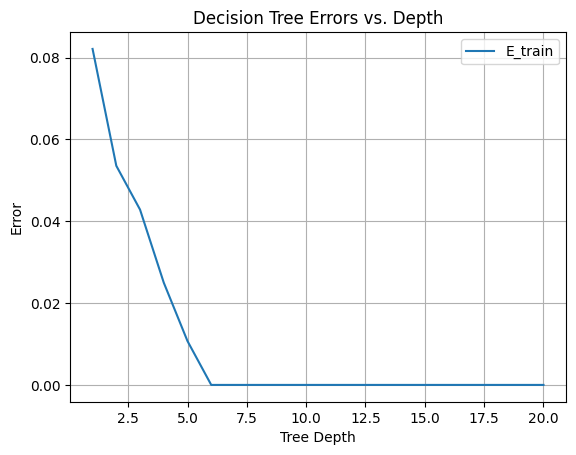

In [27]:
depths = range(1, 21)  # Try from 1 to 20

Etrain_tree_depths = []
Eholdout_tree_depths = []

for depth in depths:
    # Fit the model with current depth
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)

    # Predict on training and holdout sets
    y_train_pred = tree.predict(X_train)
    y_holdout_pred = tree.predict(X_holdout)

    # Calculate errors
    E_train = np.mean(y_train != y_train_pred)
    E_holdout = np.mean(y_holdout != y_holdout_pred)

    # Record errors
    Etrain_tree_depths.append(E_train)
    Eholdout_tree_depths.append(E_holdout)

# Plot the results
plt.plot(depths, Etrain_tree_depths, label="E_train")
plt.xlabel("Tree Depth")
plt.ylabel("Error")
plt.title("Decision Tree Errors vs. Depth")
plt.legend()
plt.grid(True)
plt.show()


## varying ensemble sizes

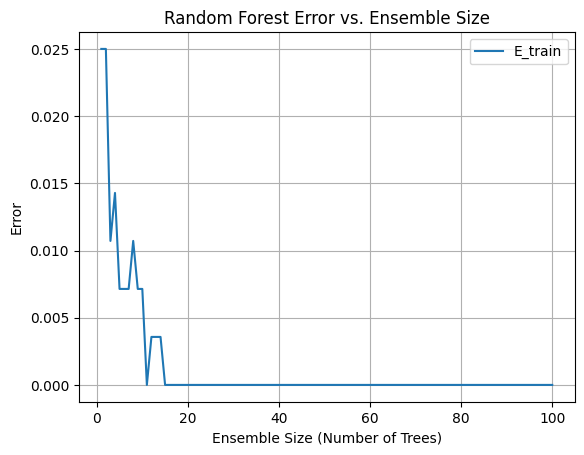

In [28]:
# Define ensemble sizes (number of trees)
ensemble_sizes = np.arange(1, 101)  # 1 to 100 trees

Etrain_forest_sizes = []
Eholdout_forest_sizes = []

for size in ensemble_sizes:
    # Fit the Random Forest with current number of trees
    forest = RandomForestClassifier(n_estimators=size, random_state=42)
    forest.fit(X_train, y_train)

    # Predict on training and holdout sets
    y_train_pred = forest.predict(X_train)
    y_holdout_pred = forest.predict(X_holdout)

    # Calculate errors
    E_train = np.mean(y_train != y_train_pred)
    E_holdout = np.mean(y_holdout != y_holdout_pred)

    # Record errors
    Etrain_forest_sizes.append(E_train)
    Eholdout_forest_sizes.append(E_holdout)

# Plot the results
plt.plot(ensemble_sizes, Etrain_forest_sizes, label="E_train")
plt.xlabel("Ensemble Size (Number of Trees)")
plt.ylabel("Error")
plt.title("Random Forest Error vs. Ensemble Size")
plt.legend()
plt.grid(True)
plt.show()

# its pretty volatile, probably due to inherent randomness in how the forest is built

## Q4: In lectures you have heard that bagging can improve performance by reducing the variance component of the error. Estimate the variance of your single decision tree and your bagged ensemble and see if this is the case for this problem.

- we're testing the claim that bagging reduces variance component of model error

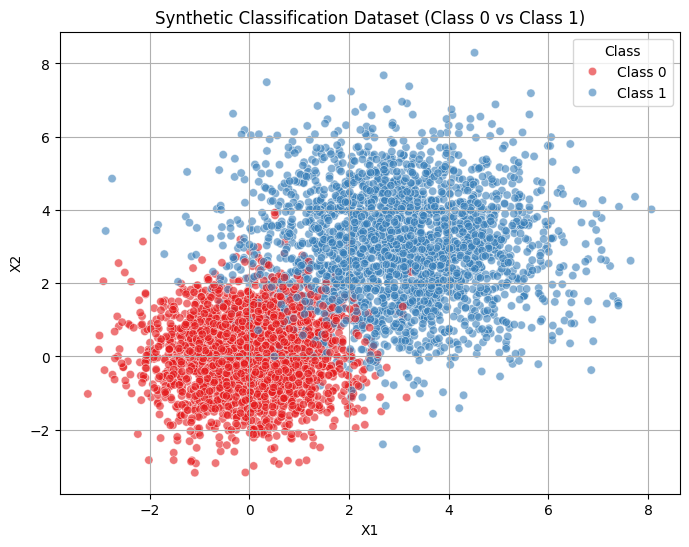

In [29]:
##### generating synthetic dataset #########

"""
- generate 5000 datapoints
- class 0 from normal dist with mean 0 and std 1
- class 1 from normal dist with mean 3 and std 1.5
- creates some overlap but maintains separability
- combine and shuffle
"""
from sklearn.utils import shuffle
import seaborn as sns

N = 5000  # total size
np.random.seed(42)

# class 0 = 2500 samples
X0 = np.random.normal(loc=0, scale=1, size=(N//2, 2))
y0 = np.zeros(N//2)

# class 1 = 2500 samples
X1 = np.random.normal(loc=3, scale=1.5, size=(N//2, 2))
y1 = np.ones(N//2)

# Combine and shuffle
X = np.vstack((X0, X1))
y = np.hstack((y0, y1))

data = pd.DataFrame(X, columns=["X1", "X2"])
data["Y"] = y.astype(int)
data = shuffle(data, random_state=42).reset_index(drop=True)

plt.figure(figsize=(8, 6))
data["Class"] = data["Y"].map({0: "Class 0", 1: "Class 1"})
sns.scatterplot(data=data, x='X1', y='X2', hue='Class', palette='Set1', alpha=0.6)
plt.title("Synthetic Classification Dataset (Class 0 vs Class 1)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(title="Class")
plt.grid(True)
plt.show()


In [30]:
##### split into 10 parts and estimate error + variance for decision tree ####
"""
for each fold
- train the decision tree on 9/10 of the data
- evaluate training and holdout error on 1/10 left out

then compute mean holdout errors and variance of holdout errors across the folds
"""
num_parts = 10
split_data = np.array_split(data, num_parts)
Etrain_tree_parts = []
Eholdout_tree_parts = []

for i in range(num_parts):
    holdout = split_data[i]
    train_parts = split_data[:i] + split_data[i+1:]
    train = pd.concat(train_parts)

    X_train, y_train = train[["X1", "X2"]], train["Y"]
    X_holdout, y_holdout = holdout[["X1", "X2"]], holdout["Y"]

    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)

    Etrain = np.mean(tree.predict(X_train) != y_train)
    Eholdout = np.mean(tree.predict(X_holdout) != y_holdout)

    Etrain_tree_parts.append(Etrain)
    Eholdout_tree_parts.append(Eholdout)

Etrain_tree_mean = np.mean(Etrain_tree_parts)
Eholdout_tree_mean = np.mean(Eholdout_tree_parts)
Eholdout_tree_var = np.var(Eholdout_tree_parts)

print("Decision tree results")
print("mean of the train error:", round(Etrain_tree_mean, 6))
print("mean of the holdout error:", round(Eholdout_tree_mean, 4))
print("est variance of holdout error:", round(Eholdout_tree_var, 6))

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Decision tree results
mean of the train error: 0.0
mean of the holdout error: 0.0666
est variance of holdout error: 0.000127


In [31]:
### repeat for random forest ####

Etrain_forest_parts = []
Eholdout_forest_parts = []

for i in range(num_parts):
    holdout = split_data[i]
    train_parts = split_data[:i] + split_data[i+1:]
    train = pd.concat(train_parts)

    X_train, y_train = train[["X1", "X2"]], train["Y"]
    X_holdout, y_holdout = holdout[["X1", "X2"]], holdout["Y"]

    forest = RandomForestClassifier(n_estimators=100, random_state=42)
    forest.fit(X_train, y_train)

    Etrain = np.mean(forest.predict(X_train) != y_train)
    Eholdout = np.mean(forest.predict(X_holdout) != y_holdout)

    Etrain_forest_parts.append(Etrain)
    Eholdout_forest_parts.append(Eholdout)

Etrain_forest_mean = np.mean(Etrain_forest_parts)
Eholdout_forest_mean = np.mean(Eholdout_forest_parts)
Eholdout_forest_var = np.var(Eholdout_forest_parts)

print("Random Forest Results")
print("mean of train error:", round(Etrain_forest_mean, 6))
print("mean of holdout error:", round(Eholdout_forest_mean, 4))
print("Est variance of holdout error:", round(Eholdout_forest_var, 6))


"""
- Decision Tree perfectly fits the training data (E_train = 0), but has higher holdout error and higher variance across folds
- The Random Forest also fits the training data closely, but generalises better and has lower variance which is consistent with the effect of bagging.

"""

Random Forest Results
mean of train error: 0.000111
mean of holdout error: 0.05
Est variance of holdout error: 7.6e-05


## Q5: Fit a boosting ensemble method to the initial training data using the AdaBoost algorithm. Calculate Etrain and Ehold-out for the ensemble.

In [32]:
from sklearn.ensemble import AdaBoostClassifier

# an adaboost ensemble with 100 weak learners
boost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    random_state=42
)
boost.fit(X_train, y_train)

# pred on training and holdout sets
y_train_pred = boost.predict(X_train)
y_holdout_pred = boost.predict(X_holdout)

# error rates
Etrain_boost = np.mean(y_train_pred != y_train)
Eholdout_boost = np.mean(y_holdout_pred != y_holdout)

print("E_train:", Etrain_boost)
print("E_hold-out:", Eholdout_boost)


E_train: 0.04555555555555556
E_hold-out: 0.036
